"""
AI-Driven Road Accident Analysis & Prediction System
Analyzes historical accident data to identify risk factors and predict accident hotspots
Uses ML algorithms (Linear Regression, Random Forest, XGBoost) for predictive modeling
Generates interactive visualizations and risk heatmaps for traffic management
"""

=== AI-Driven Traffic Accident Analysis and Prediction System ===

[1/5] Loading and preprocessing data...
Loading data from road_accident_data.csv...
Cleaning data...
Found accident columns: ['Road Accidents  during 2018', 'Road Accidents  during 2019', 'Road Accidents  during 2020', 'Accidents  Per Lakh Population - 2017', 'Total Number of Accidents  Per Lakh Population - 2018', 'Total Number of Accidents  Per Lakh Population - 2019', 'Total Number of Accidents  Per Lakh Population - 2020', 'Accidents per 10,000 Vehicles - 2017', 'Accidents per 10,000 Vehicles - 2018', 'Accidents per 10,000 Vehicles - 2019', 'Accidents per 10,000 Km of Roads - 2017', 'Accidents per 10,000 Km of Roads - 2018', 'Road Accidents per 10,000 Vehicles- 2016', 'Road Accidents per 10,000 Vehicles- 2017', 'Road Accidents per 10,000 Vehicles- 2018', 'Road Accidents per 10,000 Vehicles- 2019']
Data loaded and preprocessed successfully
Dataset shape: (37, 46)

[2/5] Performing exploratory data analysis...

=== Ex

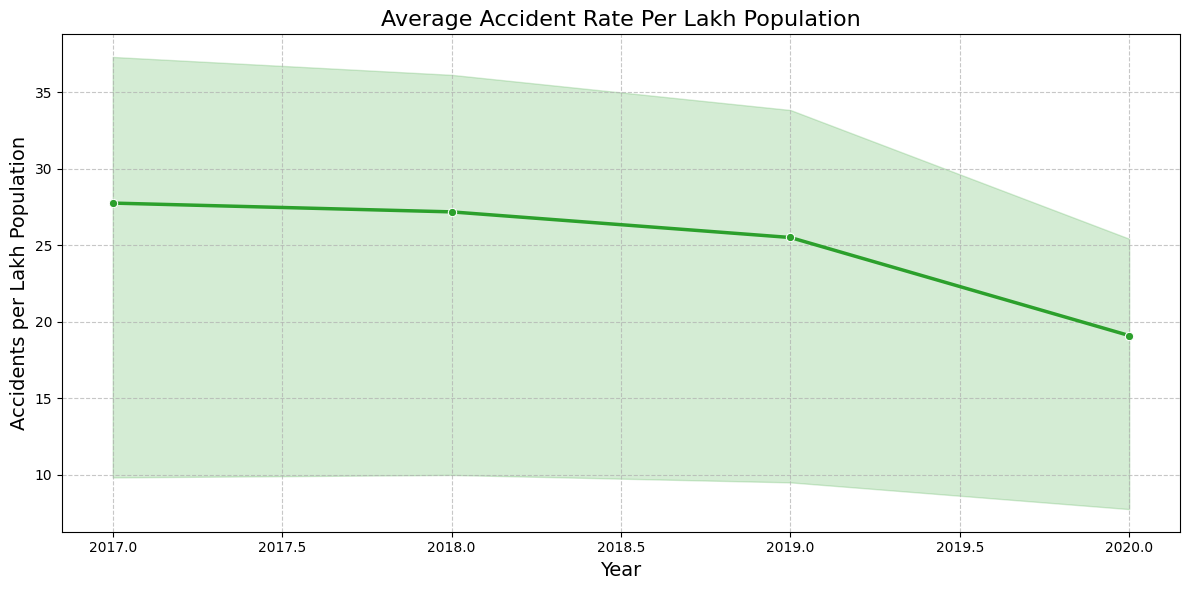

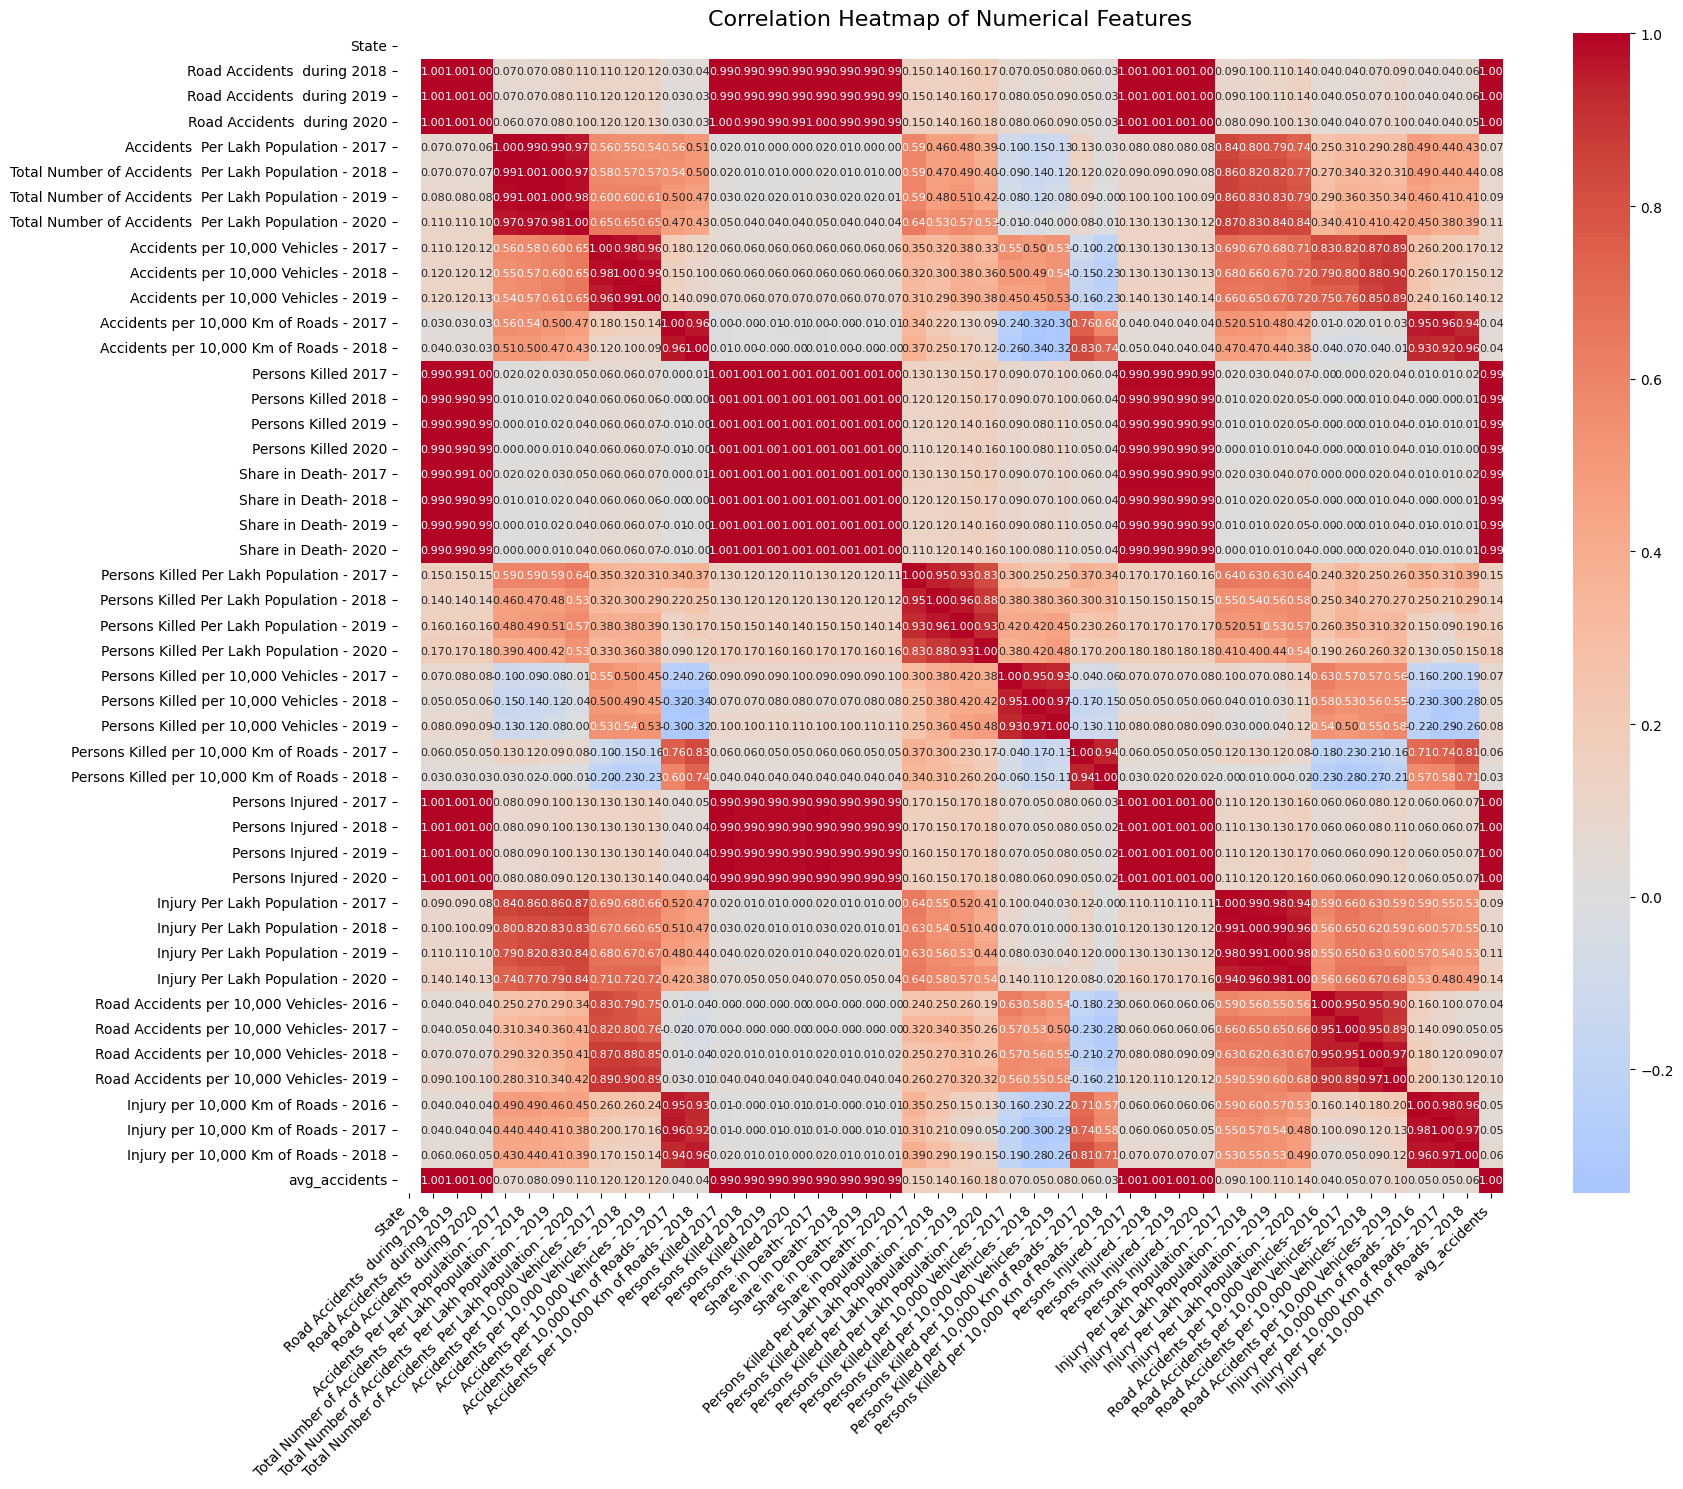


[3/5] Performing feature engineering...

Performing feature engineering...
Selected 14 features for modeling
Feature engineering completed successfully

Data verification:
Features shape: (37, 14)
Target contains NaN: False
Features contain NaN: False

[4/5] Building and evaluating models...

=== Model Building and Evaluation ===

=== Linear Regression ===

Linear Regression Performance:
- MAE: 717.81
- MSE: 737965.34
- RMSE: 859.05
- R2 Score: 0.92
- Cross-validated R2: 0.34 ± 0.57

=== Random Forest ===
Performing hyperparameter tuning...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 50}

Random Forest Performance:
- MAE: 558.53
- MSE: 830671.54
- RMSE: 911.41
- R2 Score: 0.91
- Cross-validated R2: 0.46 ± 0.26

=== XGBoost ===
Performing hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__learning_rate': 0.1, 'm

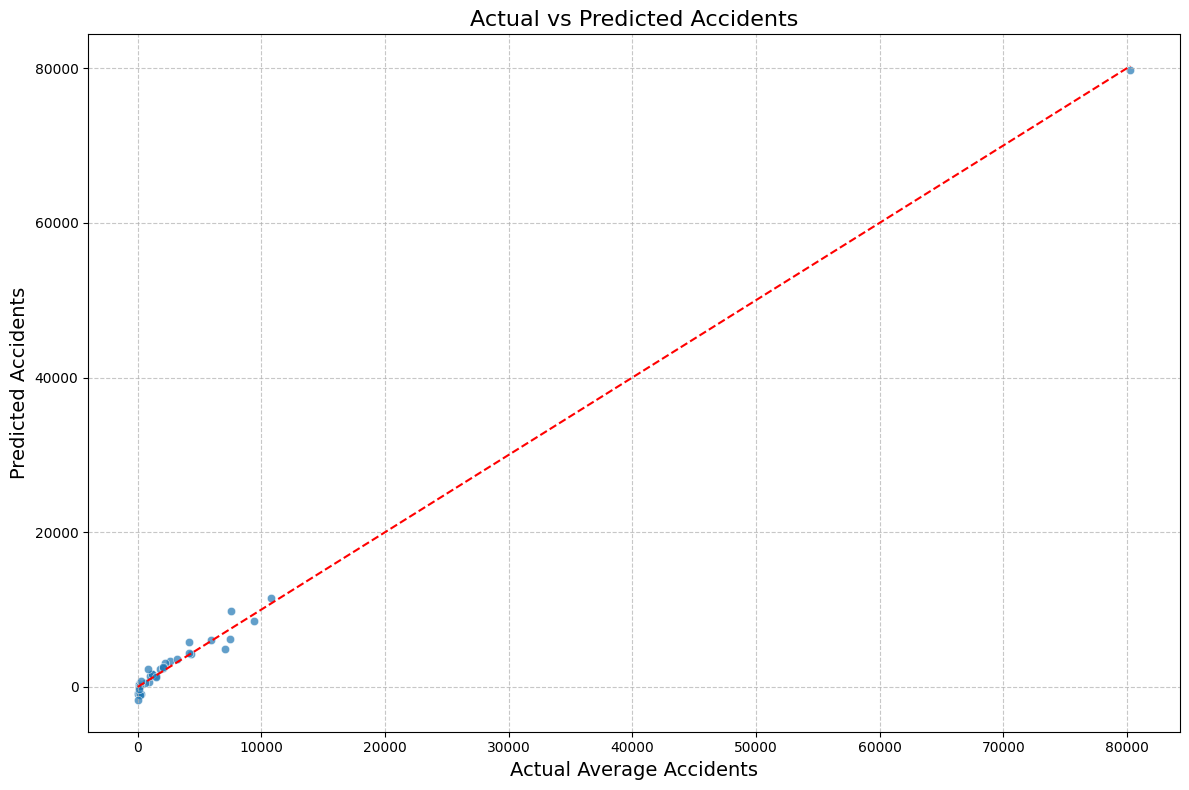

Actual vs predicted plot saved as 'actual_vs_predicted.png'

Final model saved as 'best_accident_prediction_model.pkl'

=== Analysis Completed Successfully ===


In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import folium
from folium.plugins import HeatMap
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the accident dataset with comprehensive NaN handling
    """
    try:
        # Load the dataset
        print(f"Loading data from {filepath}...")
        df = pd.read_csv(filepath)

        # Basic preprocessing steps
        print("Cleaning data...")
        # Clean column names
        df.columns = df.columns.str.strip()

        # Convert all numeric columns properly
        for col in df.columns:
            if df[col].dtype == 'object':
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except:
                    pass  # Keep as string if conversion fails

        # Handle missing values - replace with 0 only for numeric columns
        numeric_cols = df.select_dtypes(include=np.number).columns
        df[numeric_cols] = df[numeric_cols].fillna(0)

        # Remove duplicates
        df.drop_duplicates(inplace=True)

        # Create target variable (average accidents across years)
        accident_cols = [col for col in df.columns if 'Road Accidents during' in col]

        if not accident_cols:
            print("Warning: No accident columns found with 'Road Accidents during' pattern")
            # Try alternative column name patterns
            accident_cols = [col for col in df.columns if 'accident' in col.lower() or 'road accident' in col.lower()]

        if accident_cols:
            print(f"Found accident columns: {accident_cols}")
            # Calculate average accidents
            df['avg_accidents'] = df[accident_cols].mean(axis=1)

            # For states with no accident data, fill with overall median
            overall_median = df['avg_accidents'].median()
            df['avg_accidents'].fillna(overall_median, inplace=True)

            # Ensure target has no NaN values
            if df['avg_accidents'].isna().any():
                df['avg_accidents'].fillna(0, inplace=True)
        else:
            raise ValueError("No accident data columns found in dataset")

        print("Data loaded and preprocessed successfully")
        print(f"Dataset shape: {df.shape}")
        return df

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# 2. Exploratory Data Analysis
def perform_eda(df):
    """
    Perform comprehensive exploratory data analysis with visualizations
    """
    print("\n=== Exploratory Data Analysis ===")

    if df is None:
        print("No data available for EDA")
        return

    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe(include='all').transpose())

    # Accident trends over years
    year_cols = [col for col in df.columns if 'Road Accidents during' in col]

    if not year_cols:
        print("\nNo accident year columns found for trend analysis")
    else:
        yearly_accidents = df[year_cols].sum()

        # Dynamically adjust colors based on the number of years
        num_years = len(yearly_accidents)
        colors = plt.cm.viridis(np.linspace(0, 1, num_years))

        plt.figure(figsize=(12, 6))
        yearly_accidents.plot(kind='bar', color=colors)
        plt.title('Total Road Accidents by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Number of Accidents', fontsize=14)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('yearly_accidents.png', dpi=300)
        plt.show()

    # Top states with highest accidents
    if 'State/UT' in df.columns:
        state_col = 'State/UT'
    elif 'State' in df.columns:
        state_col = 'State'
    else:
        state_col = None
        print("\nNo state/UT column found for state-wise analysis")

    if state_col and year_cols:
        top_states = df.set_index(state_col)[year_cols].sum(axis=1).sort_values(ascending=False).head(10)

        plt.figure(figsize=(12, 8))
        top_states.plot(kind='barh', color='#d62728')
        plt.title('Top 10 States/UTs by Total Accidents', fontsize=16)
        plt.xlabel('Total Accidents', fontsize=14)
        plt.ylabel(state_col, fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('top_states_accidents.png', dpi=300)
        plt.show()

    # Accident rate trends
    pop_cols = [col for col in df.columns if 'Per Lakh Population' in col]
    if pop_cols:
        pop_trends = df[pop_cols].mean().reset_index()
        pop_trends.columns = ['Year', 'Accident Rate']
        pop_trends['Year'] = pop_trends['Year'].str.extract('(\d+)').astype(int)

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=pop_trends, x='Year', y='Accident Rate',
                    marker='o', linewidth=2.5, color='#2ca02c')
        plt.title('Average Accident Rate Per Lakh Population', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Accidents per Lakh Population', fontsize=14)
        plt.grid(linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('accident_rate_trend.png', dpi=300)
        plt.show()
    else:
        print("\nNo per lakh population columns found")

    # Correlation heatmap
    numerical_cols = df.select_dtypes(include=np.number).columns
    if len(numerical_cols) > 1:
        plt.figure(figsize=(18, 15))
        sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm',
                   annot_kws={'size': 8}, fmt='.2f', center=0)
        plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\nNot enough numerical columns for correlation heatmap")

# 3. Feature Engineering
def feature_engineering(df):
    """
    Prepare features for modeling with comprehensive feature selection
    """
    print("\nPerforming feature engineering...")

    if df is None:
        raise ValueError("No data available for feature engineering")

    # Select relevant features based on your dataset
    features = []

    # Add accident data columns
    for year in range(2018, 2021):
        col = f'Road Accidents during {year}'
        if col in df.columns:
            features.append(col)

    # Add population density columns
    for year in range(2017, 2021):
        col = f'Total Number of Accidents Per Lakh Population - {year}'
        if col in df.columns:
            features.append(col)

    # Add vehicle density columns
    for year in range(2017, 2020):
        col = f'Accidents per 10,000 Vehicles - {year}'
        if col in df.columns:
            features.append(col)

    # Add injury rate columns
    for year in range(2016, 2019):
        col = f'Injury per 10,000 Km of Roads - {year}'
        if col in df.columns:
            features.append(col)

    # Add persons killed columns
    for year in range(2017, 2021):
        col = f'Persons Killed {year}'
        if col in df.columns:
            features.append(col)

    # Add share in death columns
    for year in range(2017, 2021):
        col = f'Share in Death- {year}'
        if col in df.columns:
            features.append(col)

    # Ensure all features exist in the dataframe
    available_features = [f for f in features if f in df.columns]

    # Check if we have enough features
    if len(available_features) < 3:
        raise ValueError(f"Insufficient features for modeling (only {len(available_features)} found)")

    X = df[available_features]

    # Create target variable (average accidents per state)
    if 'avg_accidents' not in df.columns:
        raise ValueError("Target variable 'avg_accidents' not found in dataframe")

    y = df['avg_accidents']

    # Verify there are no NaN values in target
    if y.isna().any():
        print("Warning: NaN values found in target variable, filling with median")
        y.fillna(y.median(), inplace=True)

    print(f"Selected {len(available_features)} features for modeling")
    print("Feature engineering completed successfully")

    return X, y, df

# 4. Model Building and Evaluation
def build_and_evaluate_models(X, y):
    """
    Build and evaluate multiple ML models with comprehensive evaluation
    """
    print("\n=== Model Building and Evaluation ===")

    if X.empty or len(y) == 0:
        raise ValueError("No data available for modeling")

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Initialize models with pipelines
    models = {
        'Linear Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        'Random Forest': Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        'XGBoost': Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42))
        ])
    }

    # Hyperparameter grids for tuning
    param_grids = {
        'Random Forest': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5]
        },
        'XGBoost': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 6, 9]
        }
    }

    # Train and evaluate each model
    results = {}
    best_models = {}

    for name, model in models.items():
        print(f"\n=== {name} ===")

        try:
            # Hyperparameter tuning for tree-based models
            if name in param_grids:
                print("Performing hyperparameter tuning...")
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grids[name],
                    cv=5,
                    scoring='r2',
                    n_jobs=-1,
                    verbose=1
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(f"Best parameters: {grid_search.best_params_}")
            else:
                best_model = model.fit(X_train, y_train)

            # Make predictions
            y_pred = best_model.predict(X_test)

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            # Cross-validation
            cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')

            # Store results
            results[name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'CV R2 Mean': np.mean(cv_scores),
                'CV R2 Std': np.std(cv_scores)
            }

            # Store best model
            best_models[name] = best_model

            # Print results
            print(f"\n{name} Performance:")
            print(f"- MAE: {mae:.2f}")
            print(f"- MSE: {mse:.2f}")
            print(f"- RMSE: {rmse:.2f}")
            print(f"- R2 Score: {r2:.2f}")
            print(f"- Cross-validated R2: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            results[name] = None
            best_models[name] = None

    return results, best_models

# 5. Visualization
def create_visualizations(df, best_model, X):
    """
    Create comprehensive visualizations including interactive plots
    """
    print("\n=== Creating Visualizations ===")

    if df is None or best_model is None:
        print("No data or model available for visualizations")
        return

    # Determine state column name
    if 'State/UT' in df.columns:
        state_col = 'State/UT'
    elif 'State' in df.columns:
        state_col = 'State'
    else:
        state_col = None

    # 1. Accident Trends by State
    if state_col and 'avg_accidents' in df.columns:
        # Get top 10 states by average accidents
        top_states = df.groupby(state_col)['avg_accidents'].mean().sort_values(ascending=False).head(10)

        # Create interactive bar chart
        fig = px.bar(
            top_states.reset_index(),
            x='avg_accidents',
            y=state_col,
            orientation='h',
            title='Top 10 States by Average Accidents',
            labels={'avg_accidents': 'Average Accidents', state_col: 'State/UT'},
            color='avg_accidents',
            color_continuous_scale='reds'
        )
        fig.update_layout(
            plot_bgcolor='white',
            xaxis_title="Average Accidents",
            yaxis_title="State/UT",
            title_x=0.5
        )
        fig.write_html('top_states_accidents.html')
        print("Top states visualization saved as 'top_states_accidents.html'")
    else:
        print("No state column or target variable found for state-wise visualization")

    # 2. Feature Importance Plot (for tree-based models)
    if hasattr(best_model.named_steps['model'], 'feature_importances_'):
        print("\nCreating feature importance plot...")

        # Get feature importances
        importances = best_model.named_steps['model'].feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(15)

        # Create plot
        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='Importance',
            y='Feature',
            data=feature_importance,
            palette='viridis'
        )
        plt.title('Top 15 Important Features', fontsize=16)
        plt.xlabel('Importance Score', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Feature importance plot saved as 'feature_importance.png'")
    else:
        print("No feature importance available for this model type")

    # 3. Prediction vs Actual Plot
    if 'avg_accidents' in df.columns:
        try:
            X_scaled = best_model.named_steps['scaler'].transform(X)
            df['predicted_accidents'] = best_model.named_steps['model'].predict(X_scaled)

            plt.figure(figsize=(12, 8))
            sns.scatterplot(
                data=df,
                x='avg_accidents',
                y='predicted_accidents',
                alpha=0.7,
                color='#1f77b4'
            )
            plt.plot(
                [df['avg_accidents'].min(), df['avg_accidents'].max()],
                [df['avg_accidents'].min(), df['avg_accidents'].max()],
                'r--'
            )
            plt.title('Actual vs Predicted Accidents', fontsize=16)
            plt.xlabel('Actual Average Accidents', fontsize=14)
            plt.ylabel('Predicted Accidents', fontsize=14)
            plt.grid(linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Actual vs predicted plot saved as 'actual_vs_predicted.png'")
        except Exception as e:
            print(f"Error creating prediction plot: {str(e)}")
    else:
        print("No target variable found for prediction visualization")

# Main execution with comprehensive error handling
if __name__ == "__main__":
    print("=== AI-Driven Traffic Accident Analysis and Prediction System ===")

    # File path to your dataset
    data_file = 'road_accident_data.csv'

    try:
        # 1. Load and preprocess data
        print("\n[1/5] Loading and preprocessing data...")
        accident_data = load_and_preprocess_data(data_file)

        if accident_data is None:
            raise ValueError("Failed to load and preprocess data")

        # 2. Perform EDA
        print("\n[2/5] Performing exploratory data analysis...")
        perform_eda(accident_data)

        # 3. Feature engineering
        print("\n[3/5] Performing feature engineering...")
        X, y, df = feature_engineering(accident_data)

        # Data verification
        print("\nData verification:")
        print(f"Features shape: {X.shape}")
        print(f"Target contains NaN: {y.isna().any()}")
        print(f"Features contain NaN: {X.isna().any().any()}")

        if X.empty or len(y) == 0:
            raise ValueError("No features or target available for modeling")

        # 4. Build and evaluate models
        print("\n[4/5] Building and evaluating models...")
        results, models = build_and_evaluate_models(X, y)

        # Check if any models were successfully trained
        successful_models = {k:v for k,v in models.items() if v is not None}
        if not successful_models:
            raise ValueError("No models were successfully trained")

        # 5. Select best model based on R2 score
        valid_results = {k:v for k,v in results.items() if v is not None}
        if valid_results:
            best_model_name = max(valid_results, key=lambda x: valid_results[x]['R2'])
            best_model = models[best_model_name]
            print(f"\nBest model: {best_model_name} with R2 score: {valid_results[best_model_name]['R2']:.2f}")

            # 6. Create visualizations
            print("\n[5/5] Creating visualizations...")
            create_visualizations(df, best_model, X)

            # 7. Save final model
            joblib.dump(best_model, 'best_accident_prediction_model.pkl')
            print("\nFinal model saved as 'best_accident_prediction_model.pkl'")

            print("\n=== Analysis Completed Successfully ===")
        else:
            print("\nNo valid model results available")

    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        print("\n=== Analysis Failed ===")
